In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os
import warnings
warnings.filterwarnings('ignore')

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['figure.dpi'] = 300
colors = ["#B6EE56", "#D85F9C", "#EEA756", "#56EEE8"]

A search has been initiated within the folder named 'train'.
There are 1322 images in the ModerateDemented folder.
There are 1947 images in the NonDemented folder.
There are 1834 images in the VeryMildDemented folder.
There are 1826 images in the MildDemented folder.
The search has been completed.


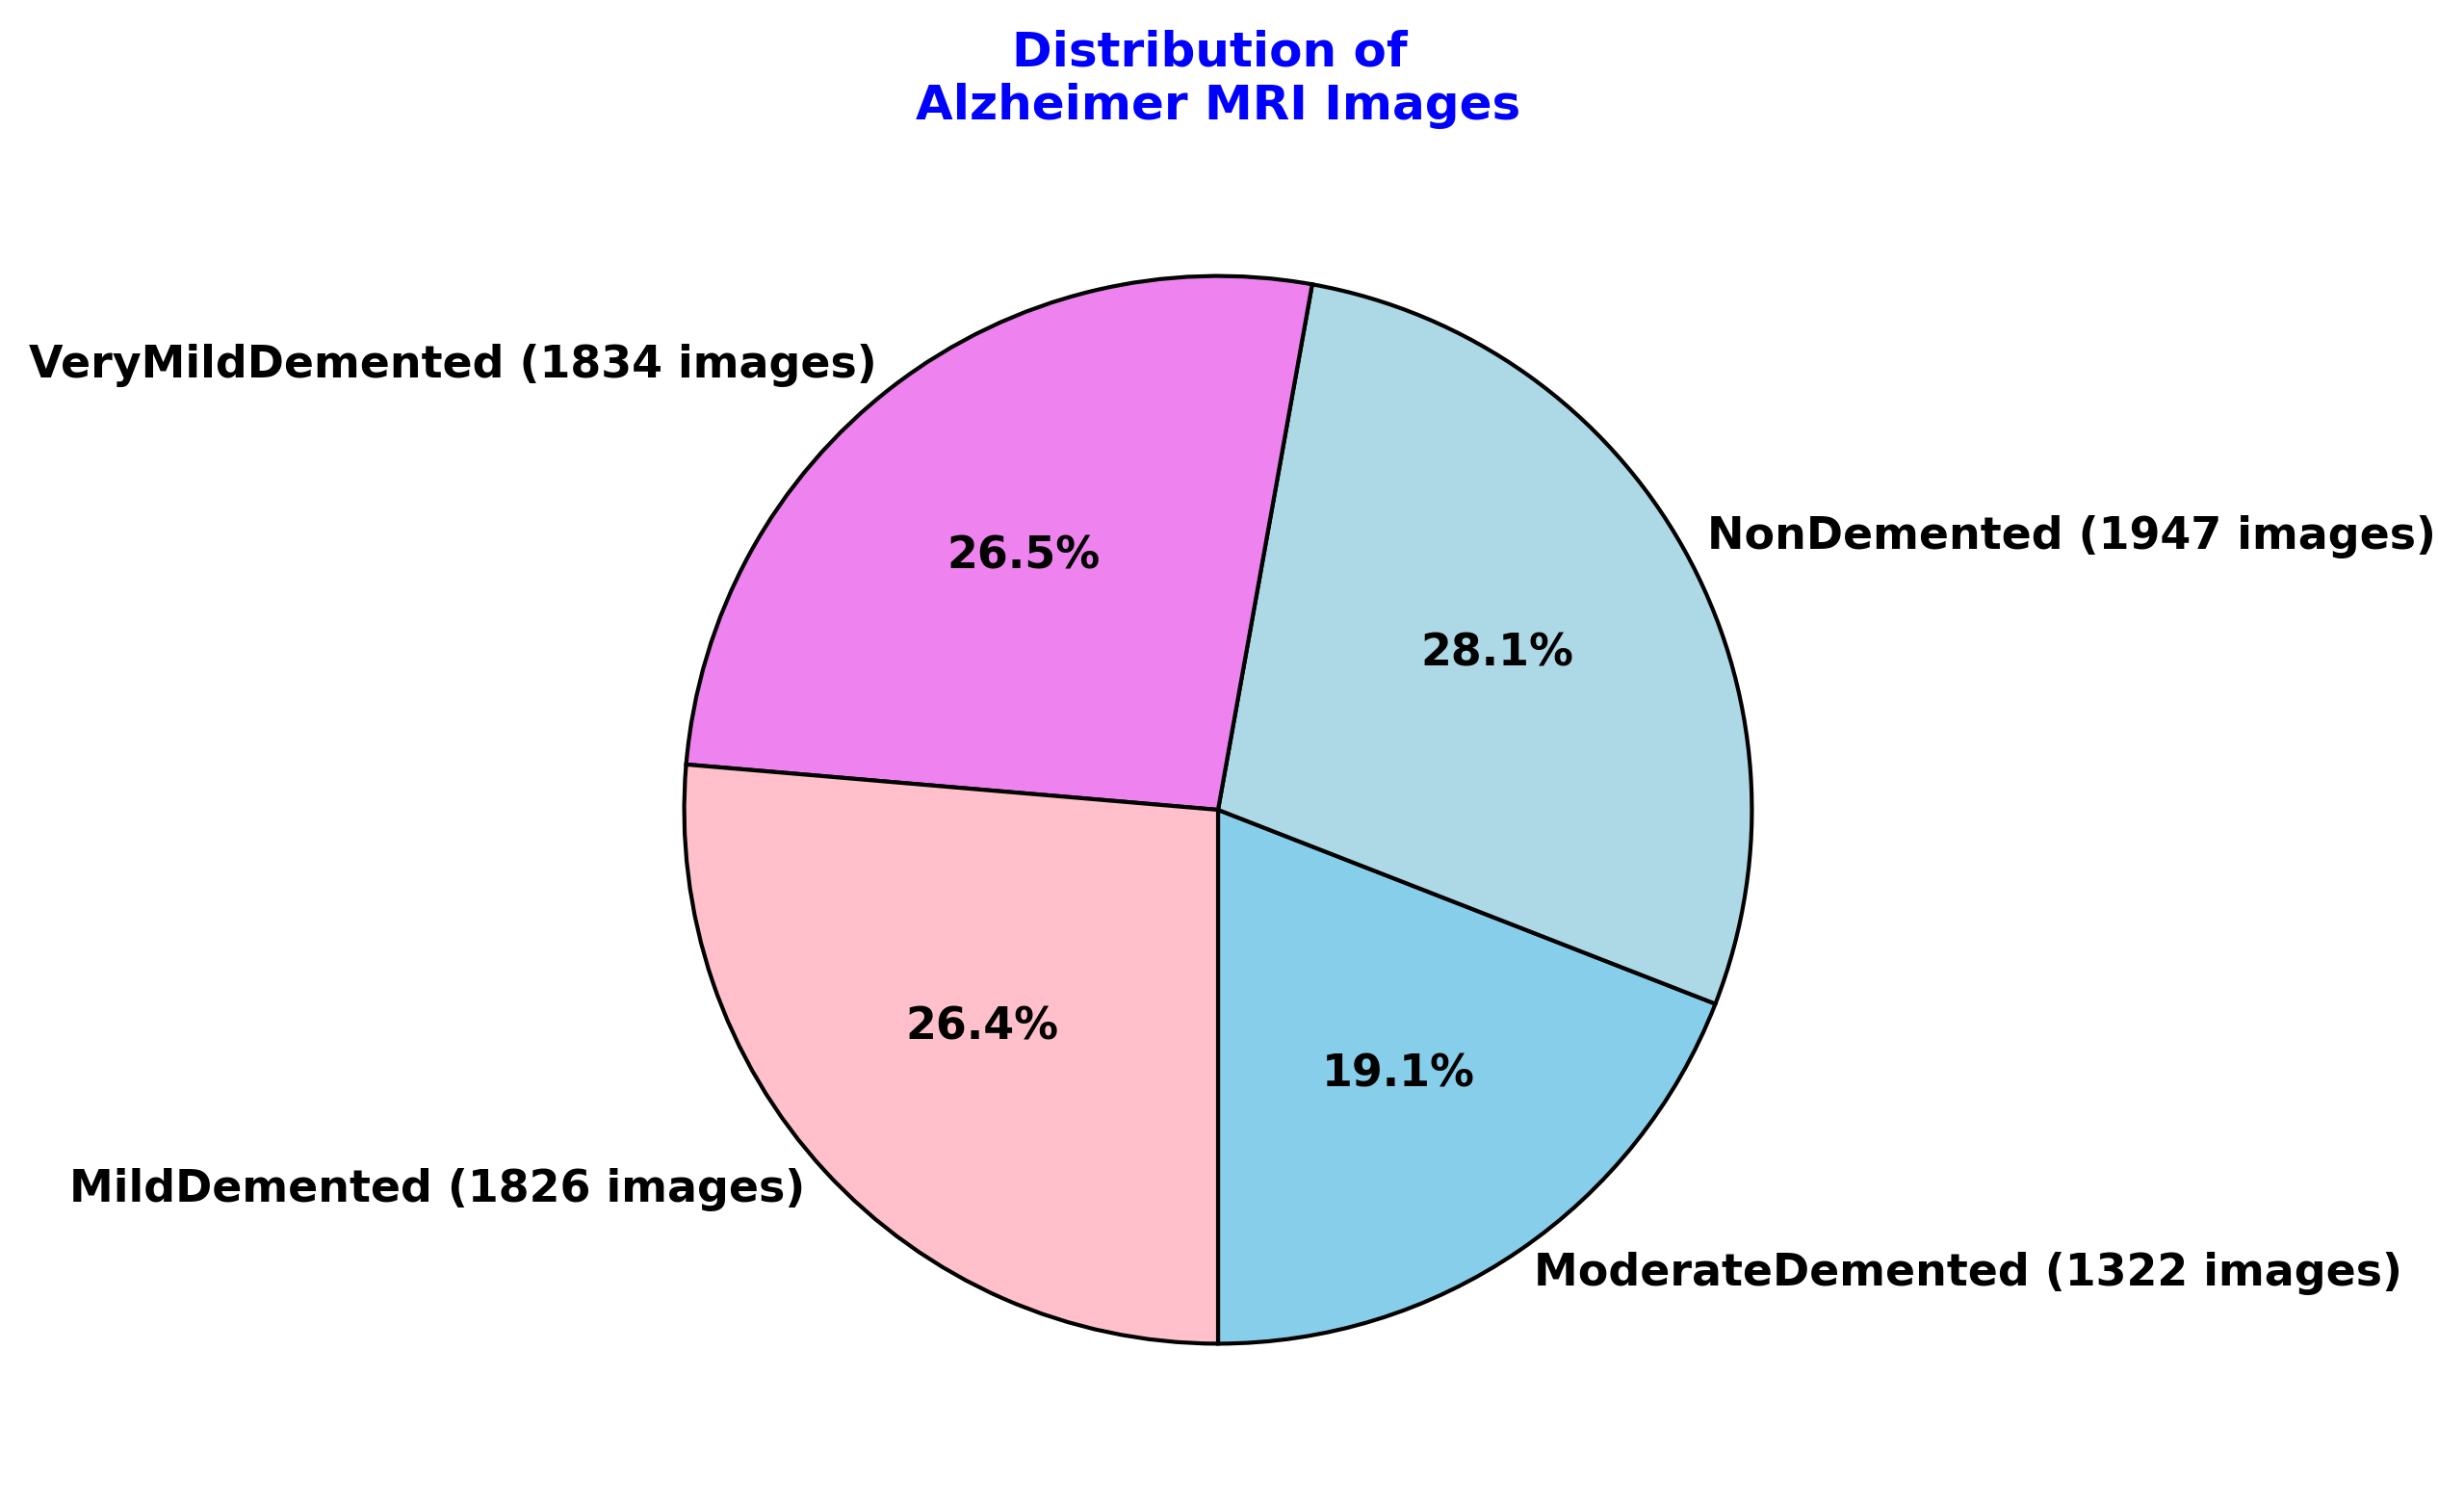

In [3]:
class_dist = {}
def image_counter(folder_path):
    basename = os.path.basename(folder_path)
    print('\033[92m'+f"A search has been initiated within the folder named '{basename}'."+'\033[0m')
    image_extensions = ['.jpg', '.jpeg', '.png']

    for root, dirs, _ in os.walk(folder_path):
        for dir_name in dirs:
            dir_path = os.path.join(root, dir_name)
            count = 0

            for filename in os.listdir(dir_path):
                file_ext = os.path.splitext(filename)[1].lower()

                if file_ext in image_extensions:
                    count += 1

            class_dist[dir_name] = count
            print(f"There are \033[35m{count}\033[0m images in the {dir_name} folder.")
    print('\033[92m'+"The search has been completed."+'\033[0m')

    keys = list(class_dist.keys())
    values = list(class_dist.values())
    explode = (0.1,)*len(keys)

    labels = [f'{key} ({value} images)' for key, value in zip(keys, values)]

    plt.pie(values, labels=labels, autopct='%1.1f%%',
            shadow=False, startangle=-90, colors=["skyblue", "lightblue", "violet", "pink"], textprops={'fontsize': 11, "fontweight" : "bold", "color":"black"},  wedgeprops=
           {'edgecolor':'black'} , labeldistance=1.05)
    plt.title("Distribution of \nAlzheimer MRI Images", size=12, fontweight="bold", color="blue")
PATH_train = '/kaggle/input/ad-train-test-validate-4-classes/train'
image_counter(PATH_train)

A search has been initiated within the folder named 'test'.
There are 526 images in the ModerateDemented folder.
There are 799 images in the NonDemented folder.
There are 769 images in the VeryMildDemented folder.
There are 782 images in the MildDemented folder.
The search has been completed.


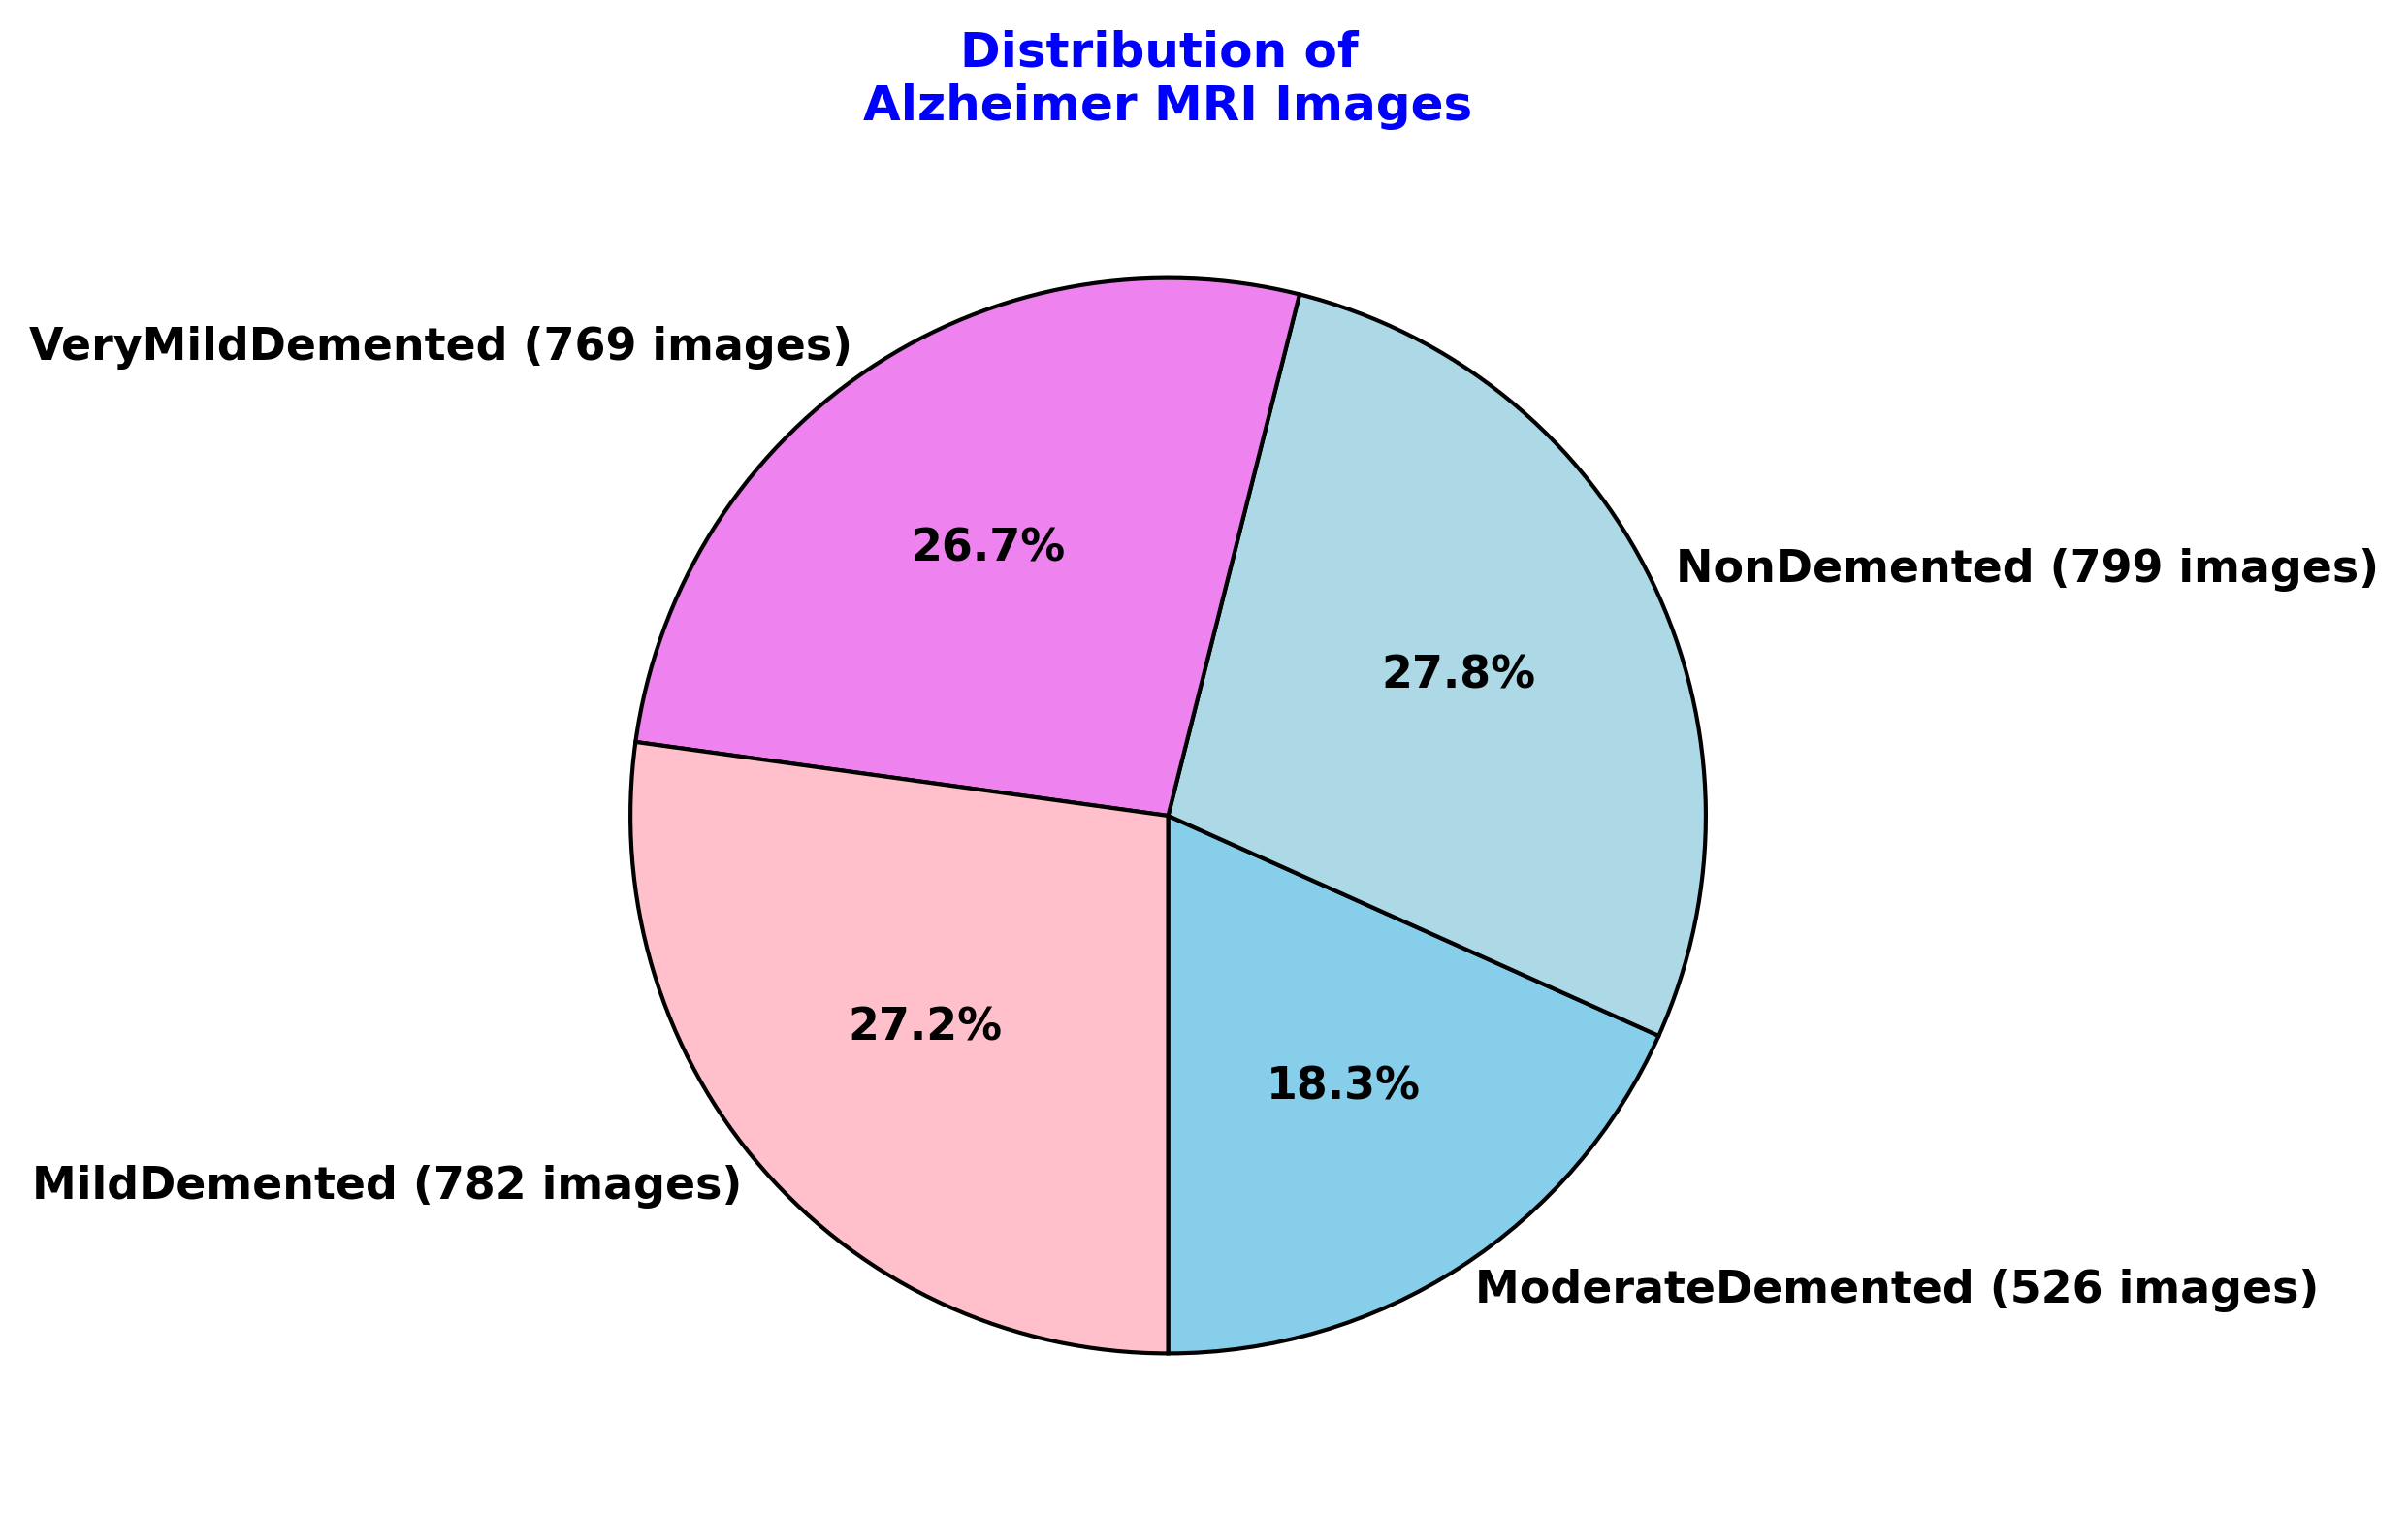

In [4]:
PATH_test = '/kaggle/input/ad-train-test-validate-4-classes/test'
image_counter(PATH_test)

A search has been initiated within the folder named 'valid'.
There are 14 images in the ModerateDemented folder.
There are 28 images in the NonDemented folder.
There are 26 images in the VeryMildDemented folder.
There are 27 images in the MildDemented folder.
The search has been completed.


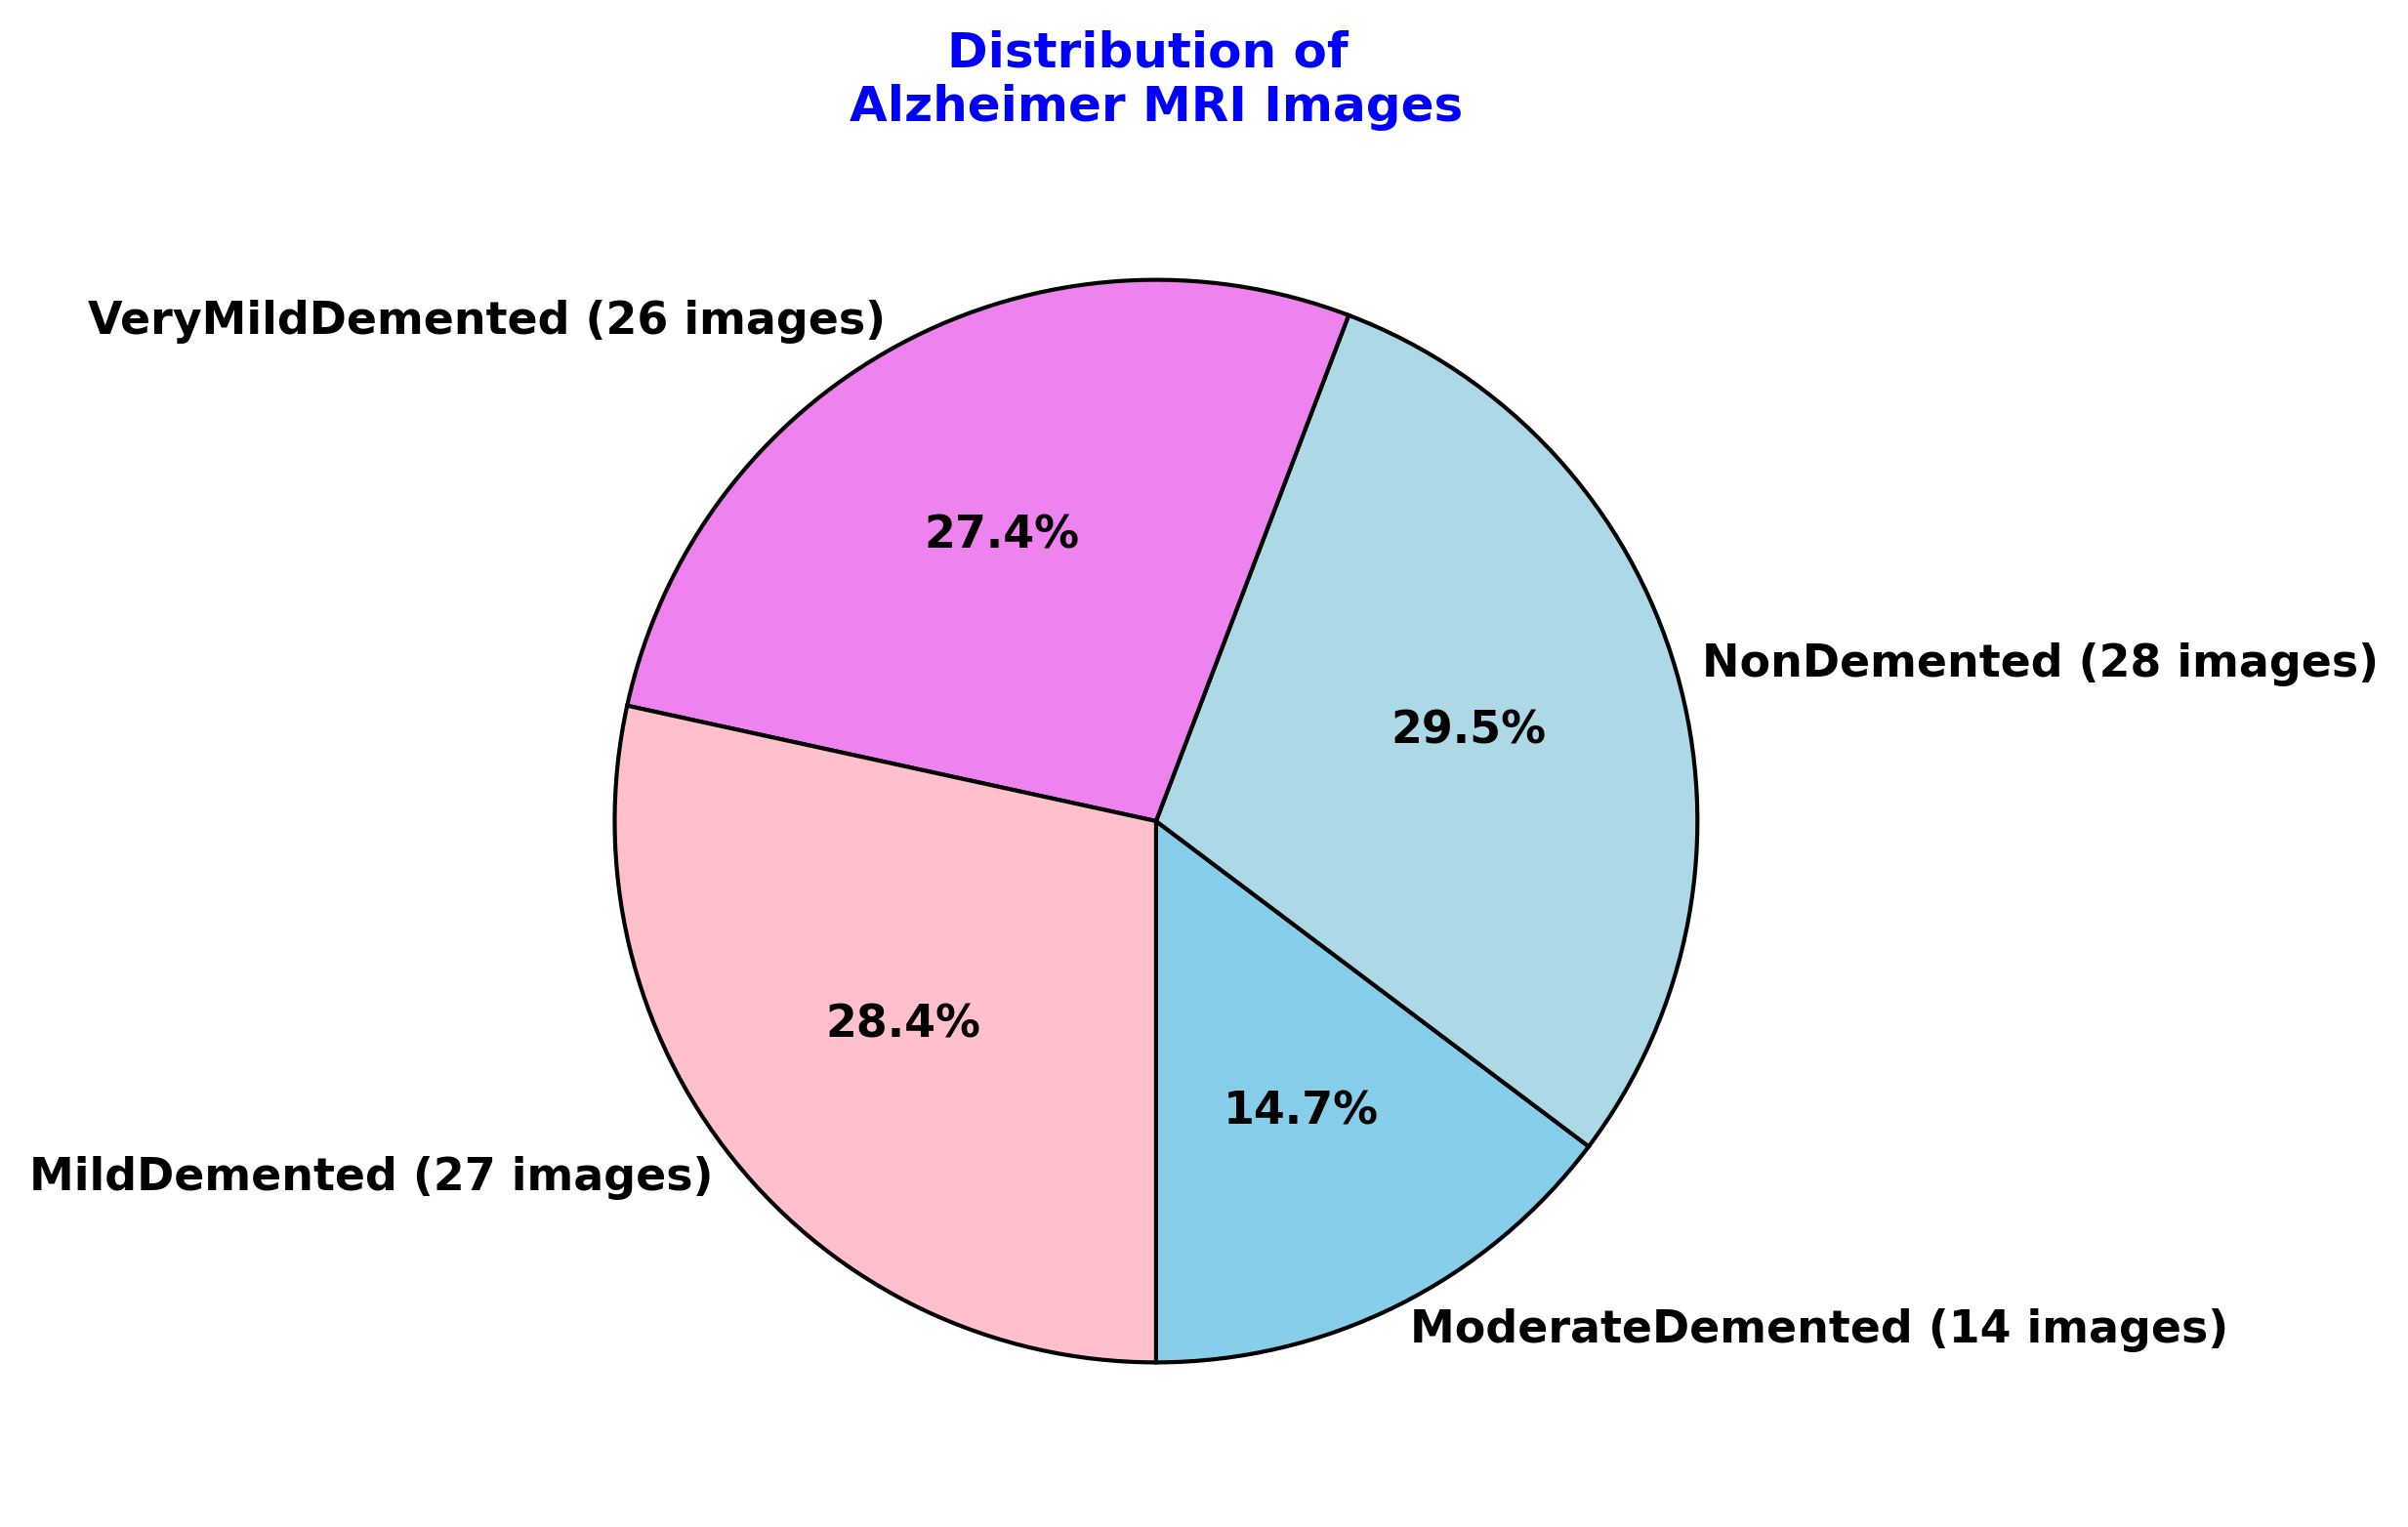

In [5]:
PATH_validate = '/kaggle/input/ad-train-test-validate-4-classes/valid'
image_counter(PATH_validate)

In [13]:
train_data = tf.keras.utils.image_dataset_from_directory(PATH_train,
                                                batch_size = 64,
                                                image_size=(240, 240),
                                                shuffle=True,
                                                seed=42,)
test_data = tf.keras.utils.image_dataset_from_directory(PATH_test,
                                                batch_size = 64,
                                                image_size=(240, 240),
                                                shuffle=True,
                                                seed=42,)
validate_data = tf.keras.utils.image_dataset_from_directory(PATH_validate,
                                                batch_size = 64,
                                                image_size=(240, 240),
                                                shuffle=True,
                                                seed=42,)
class_names = train_data.class_names

Found 6929 files belonging to 4 classes.
Found 2876 files belonging to 4 classes.
Found 95 files belonging to 4 classes.


Min and max pixel values in the batch -> 0.0 & 1.0
Min and max pixel values in the batch -> 0.0 & 1.0
Min and max pixel values in the batch -> 0.0 & 1.0


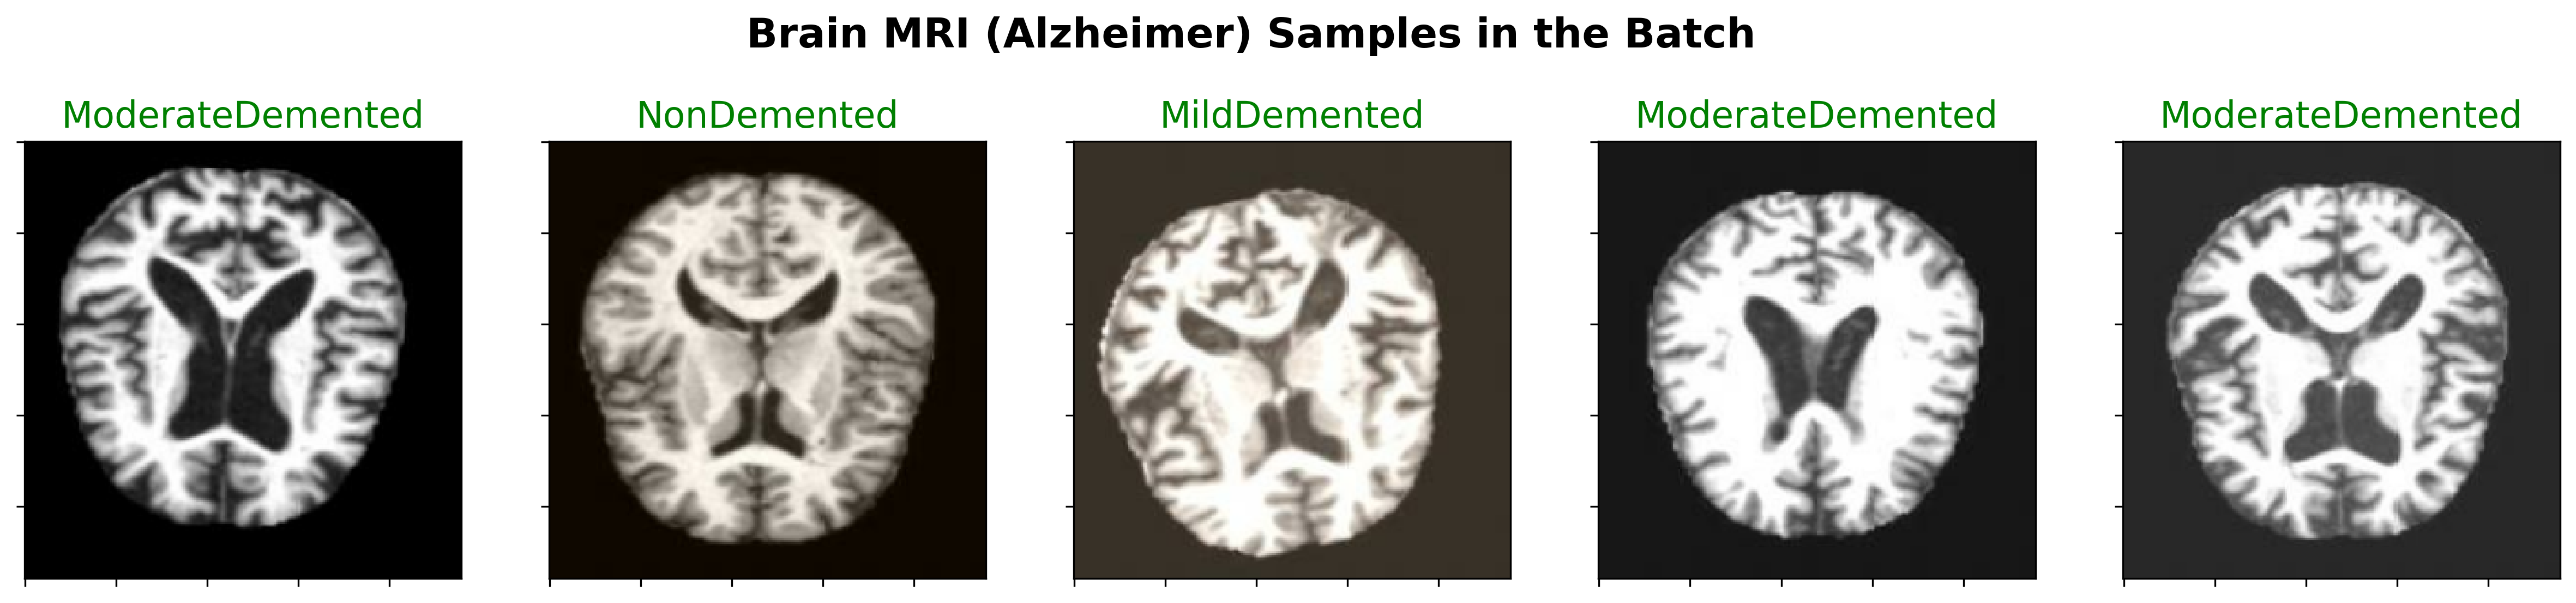

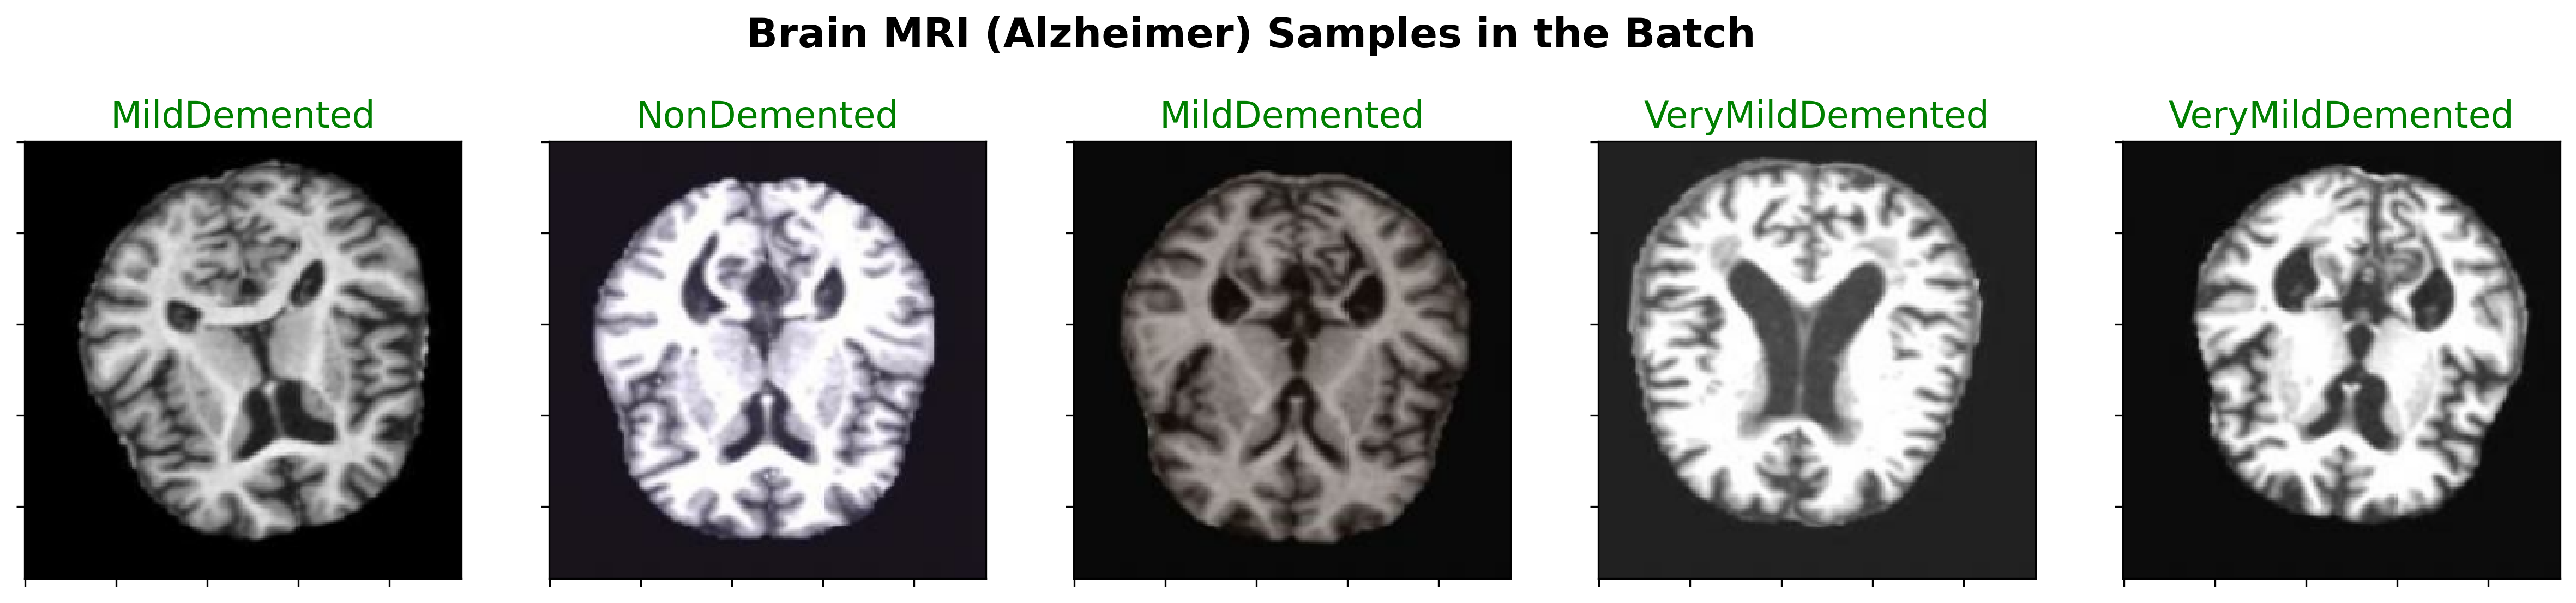

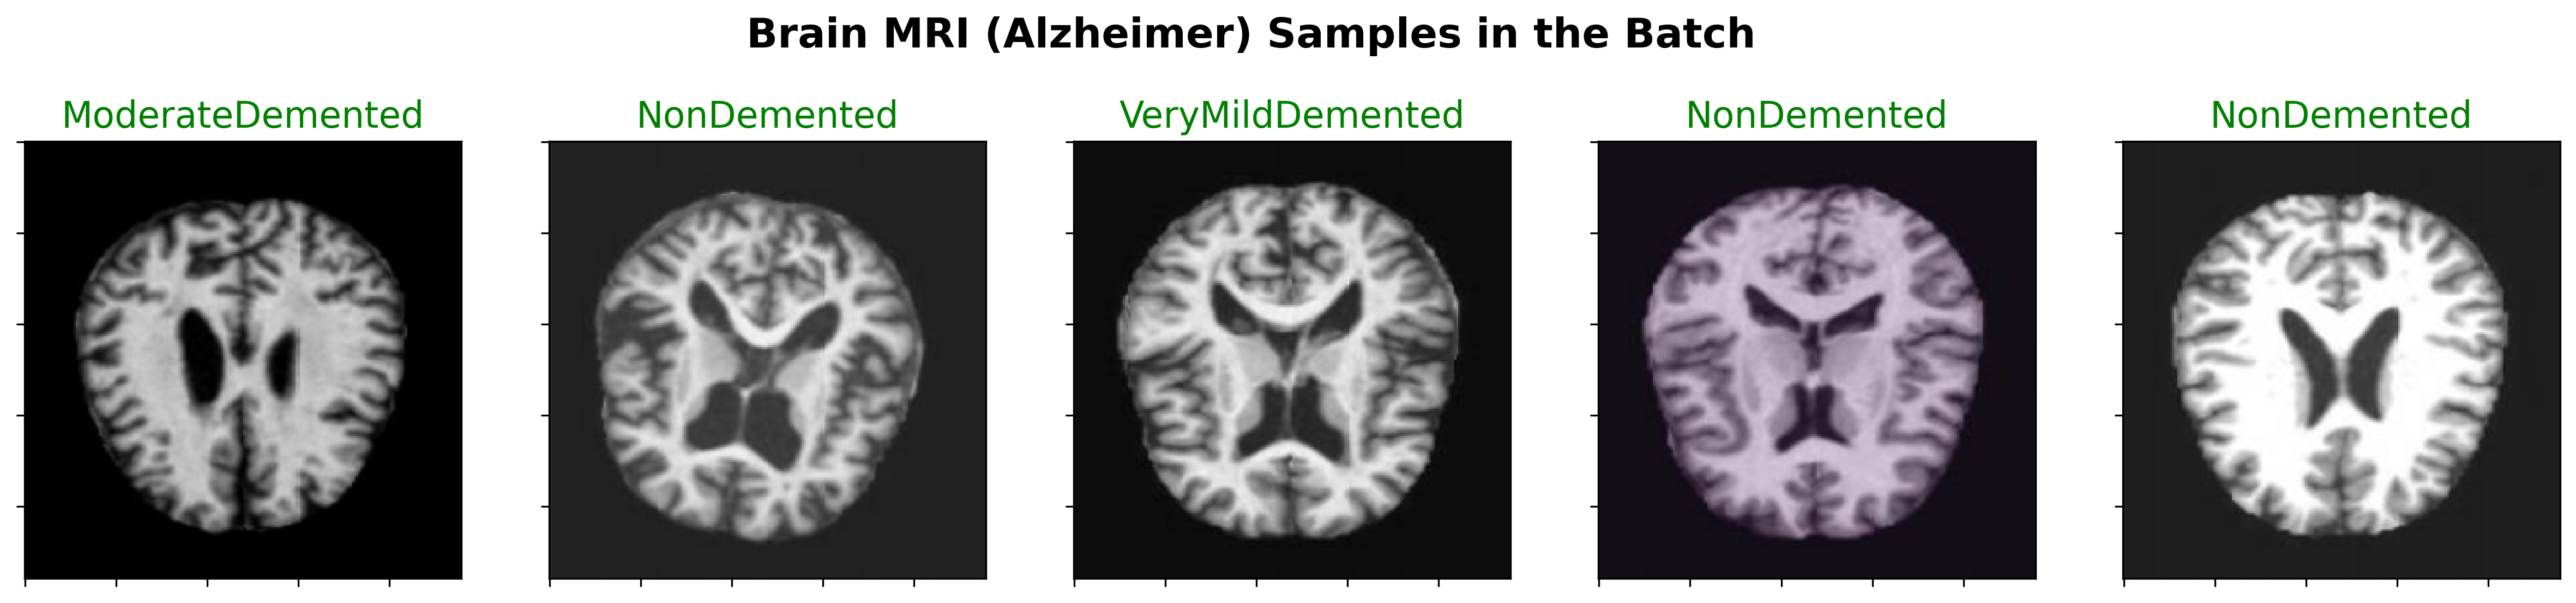

In [14]:
alz_dict = {index: img for index, img in enumerate(train_data.class_names)}

class Process:
    def __init__(self, data):
        self.data = data.map(lambda x, y: (x/255, y))

    def create_new_batch(self):
        self.batch = self.data.as_numpy_iterator().next()
        text = "Min and max pixel values in the batch ->"
        print(text, self.batch[0].min(), "&", self.batch[0].max())

    def show_batch_images(self, number_of_images=5):
        fig, ax = plt.subplots(ncols=number_of_images, figsize=(20,20), facecolor="white")
        fig.suptitle("Brain MRI (Alzheimer) Samples in the Batch", color="black",fontsize=18, fontweight='bold', y=0.6)
        for idx, img in enumerate(self.batch[0][:number_of_images]):
            ax[idx].imshow(img)
            class_no = self.batch[1][idx]
            ax[idx].set_title(alz_dict[class_no], color="green", fontsize=16)
            ax[idx].set_xticklabels([])
            ax[idx].set_yticklabels([])

train_process = Process(train_data)
train_process.create_new_batch()
train_process.show_batch_images(number_of_images=5)

test_process = Process(test_data)
test_process.create_new_batch()
test_process.show_batch_images(number_of_images=5)

validate_process = Process(validate_data)
validate_process.create_new_batch()
validate_process.show_batch_images(number_of_images=5)

In [21]:
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
def build_model():
    base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(240,240,3))
    for layer in base_model.layers:
        layer.trainable = False

    input_layer = Input(shape=(240, 240, 3))
    x = base_model(input_layer)
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.2)(x)
    output = Dense(4, activation='softmax')(x)
    model = Model(input_layer, output)
    
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=['accuracy'])
    model.summary()
    return model
model = build_model()

def checkpoint_callback():
    checkpoint_filepath = '/tmp/checkpoint/model_checkpoint.keras'

    model_checkpoint_callback = ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=False,
        save_freq='epoch',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )

    return model_checkpoint_callback

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback

checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

EPOCHS = 100
history = model.fit(train_data, epochs = EPOCHS, validation_data = validate_data)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 240, 240, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb1 (Functional)     │ (None, 8, 8, 1280)     │     6,575,239 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │        20,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 4)              │            68 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,600,923 (25.18 MB)

 Trainable params: 23,124 (90.33 KB)

 Non-trainable params: 6,577,799 (25.09 MB)

Epoch 1/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 95s 453ms/step - accuracy: 0.4310 - loss: 1.2789 - val_accuracy: 0.5579 - val_loss: 1.1105
Epoch 2/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.5953 - loss: 0.9221 - val_accuracy: 0.6000 - val_loss: 0.9633
Epoch 3/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.6281 - loss: 0.8160 - val_accuracy: 0.6632 - val_loss: 0.8038
Epoch 4/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.6514 - loss: 0.7713 - val_accuracy: 0.6737 - val_loss: 0.7359
Epoch 5/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.6805 - loss: 0.7159 - val_accuracy: 0.6842 - val_loss: 0.6729
Epoch 6/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.6816 - loss: 0.7041 - val_accuracy: 0.7053 - val_loss: 0.6025
Epoch 7/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 86ms/step - accuracy: 0.6899 - loss: 0.6757 - val_accuracy: 0.7053 - val_loss: 0.5885
Epoch 8/100
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.6914 - loss: 

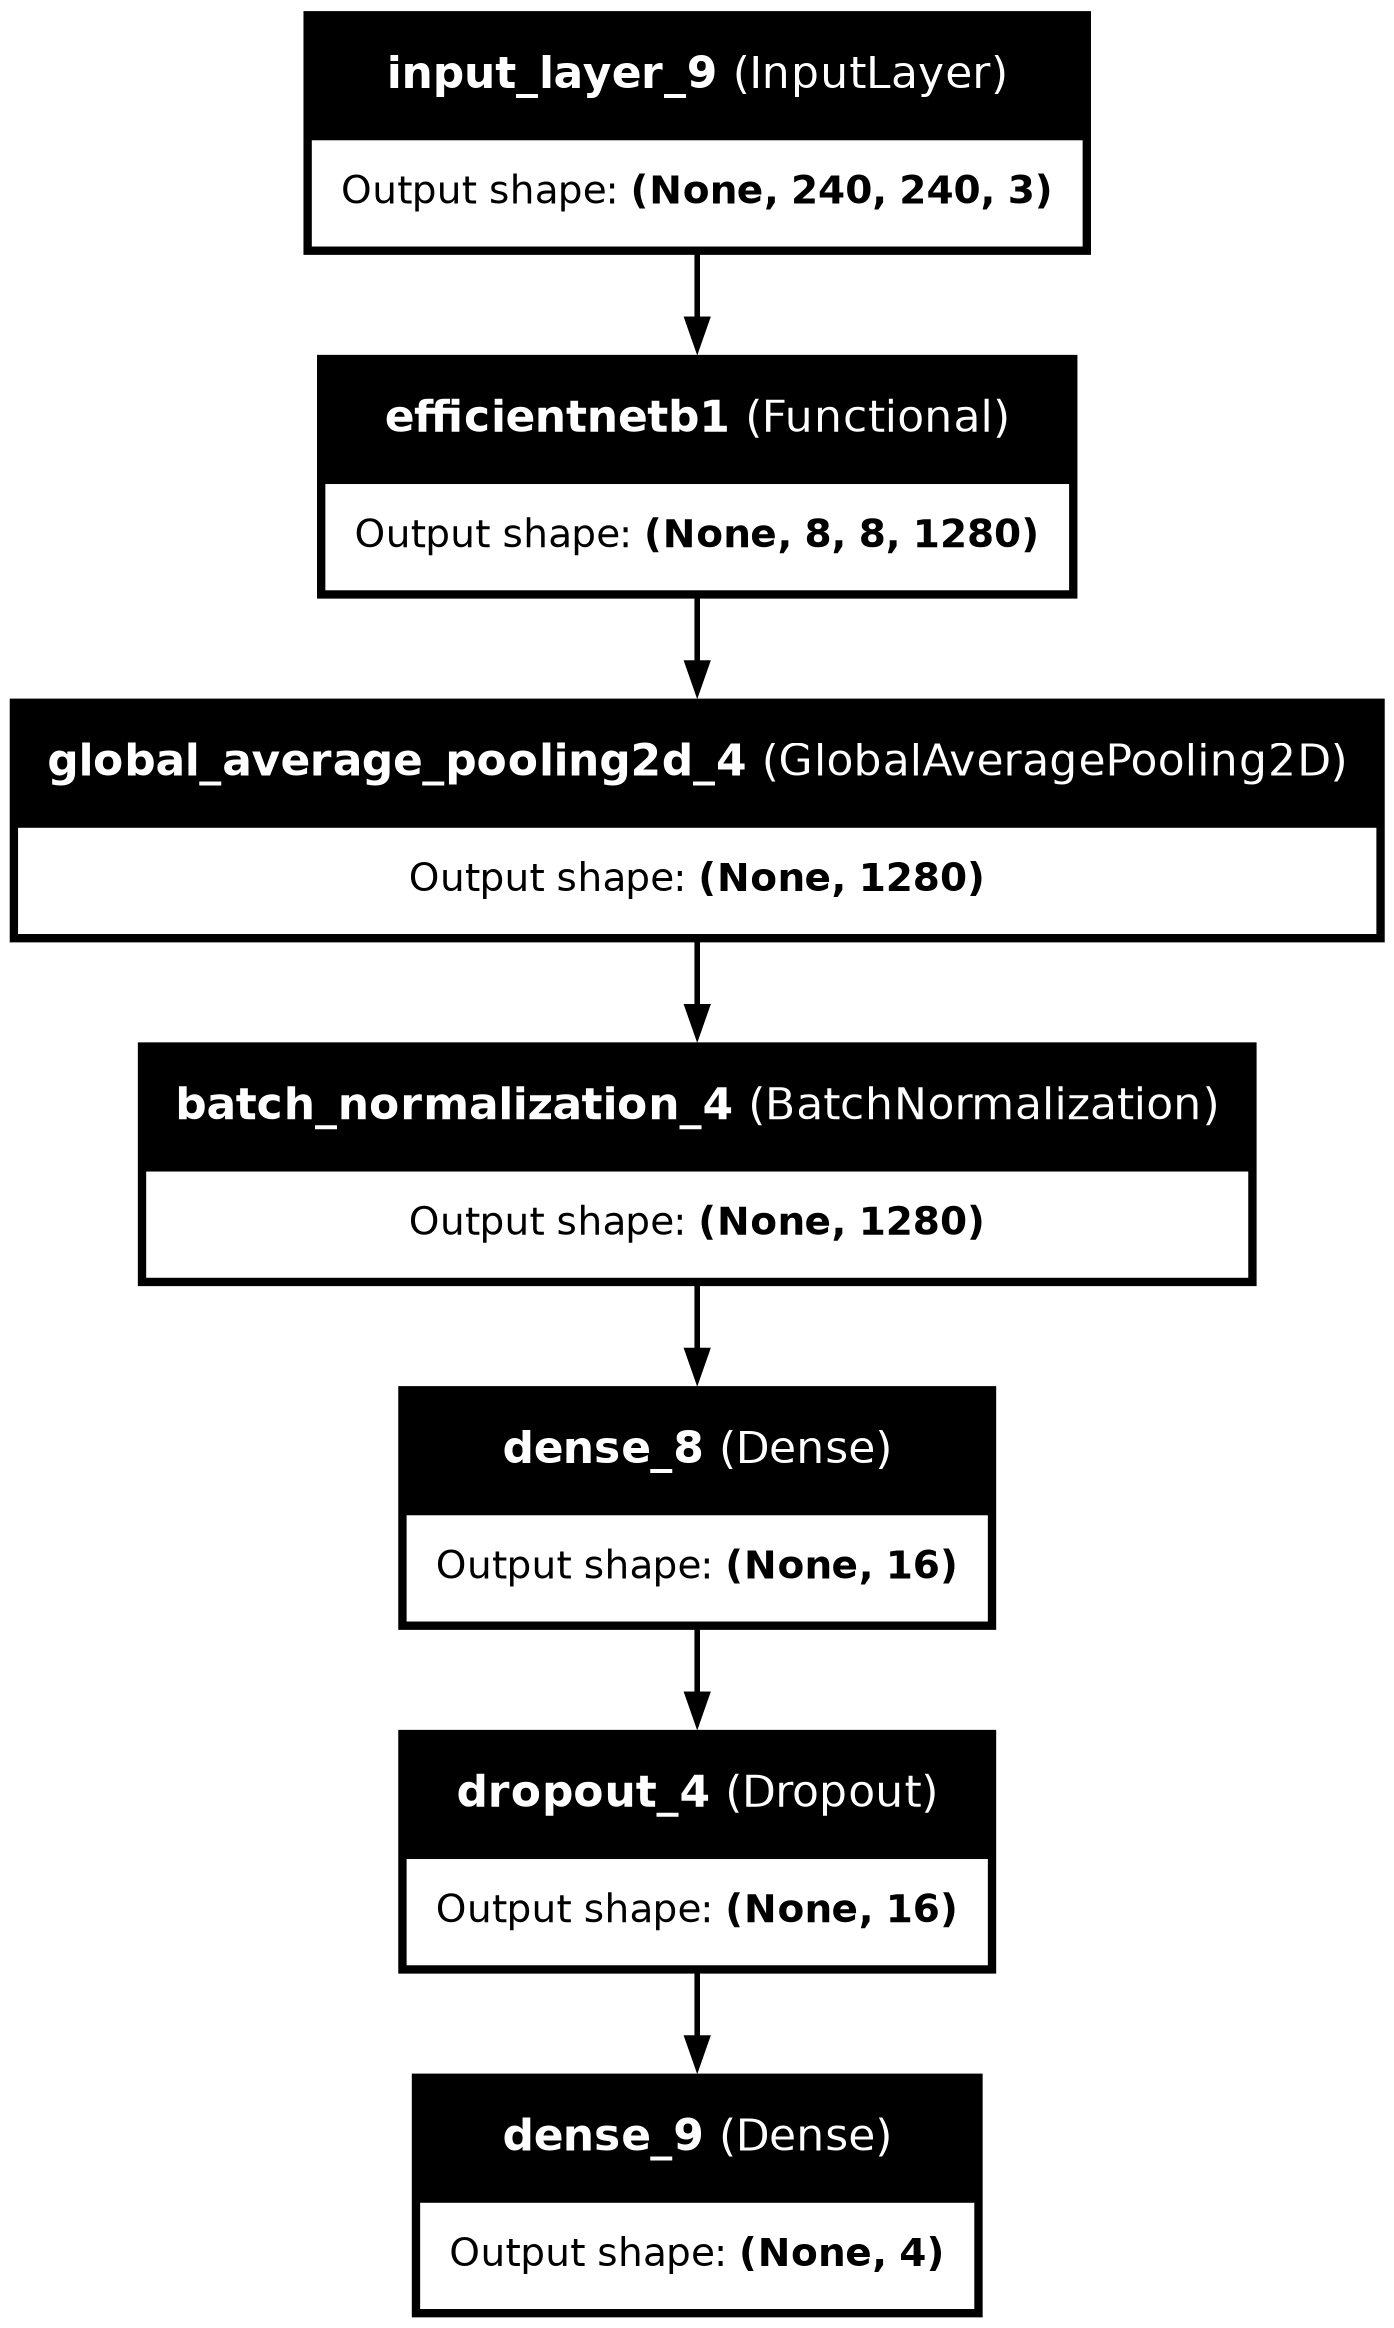

In [22]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

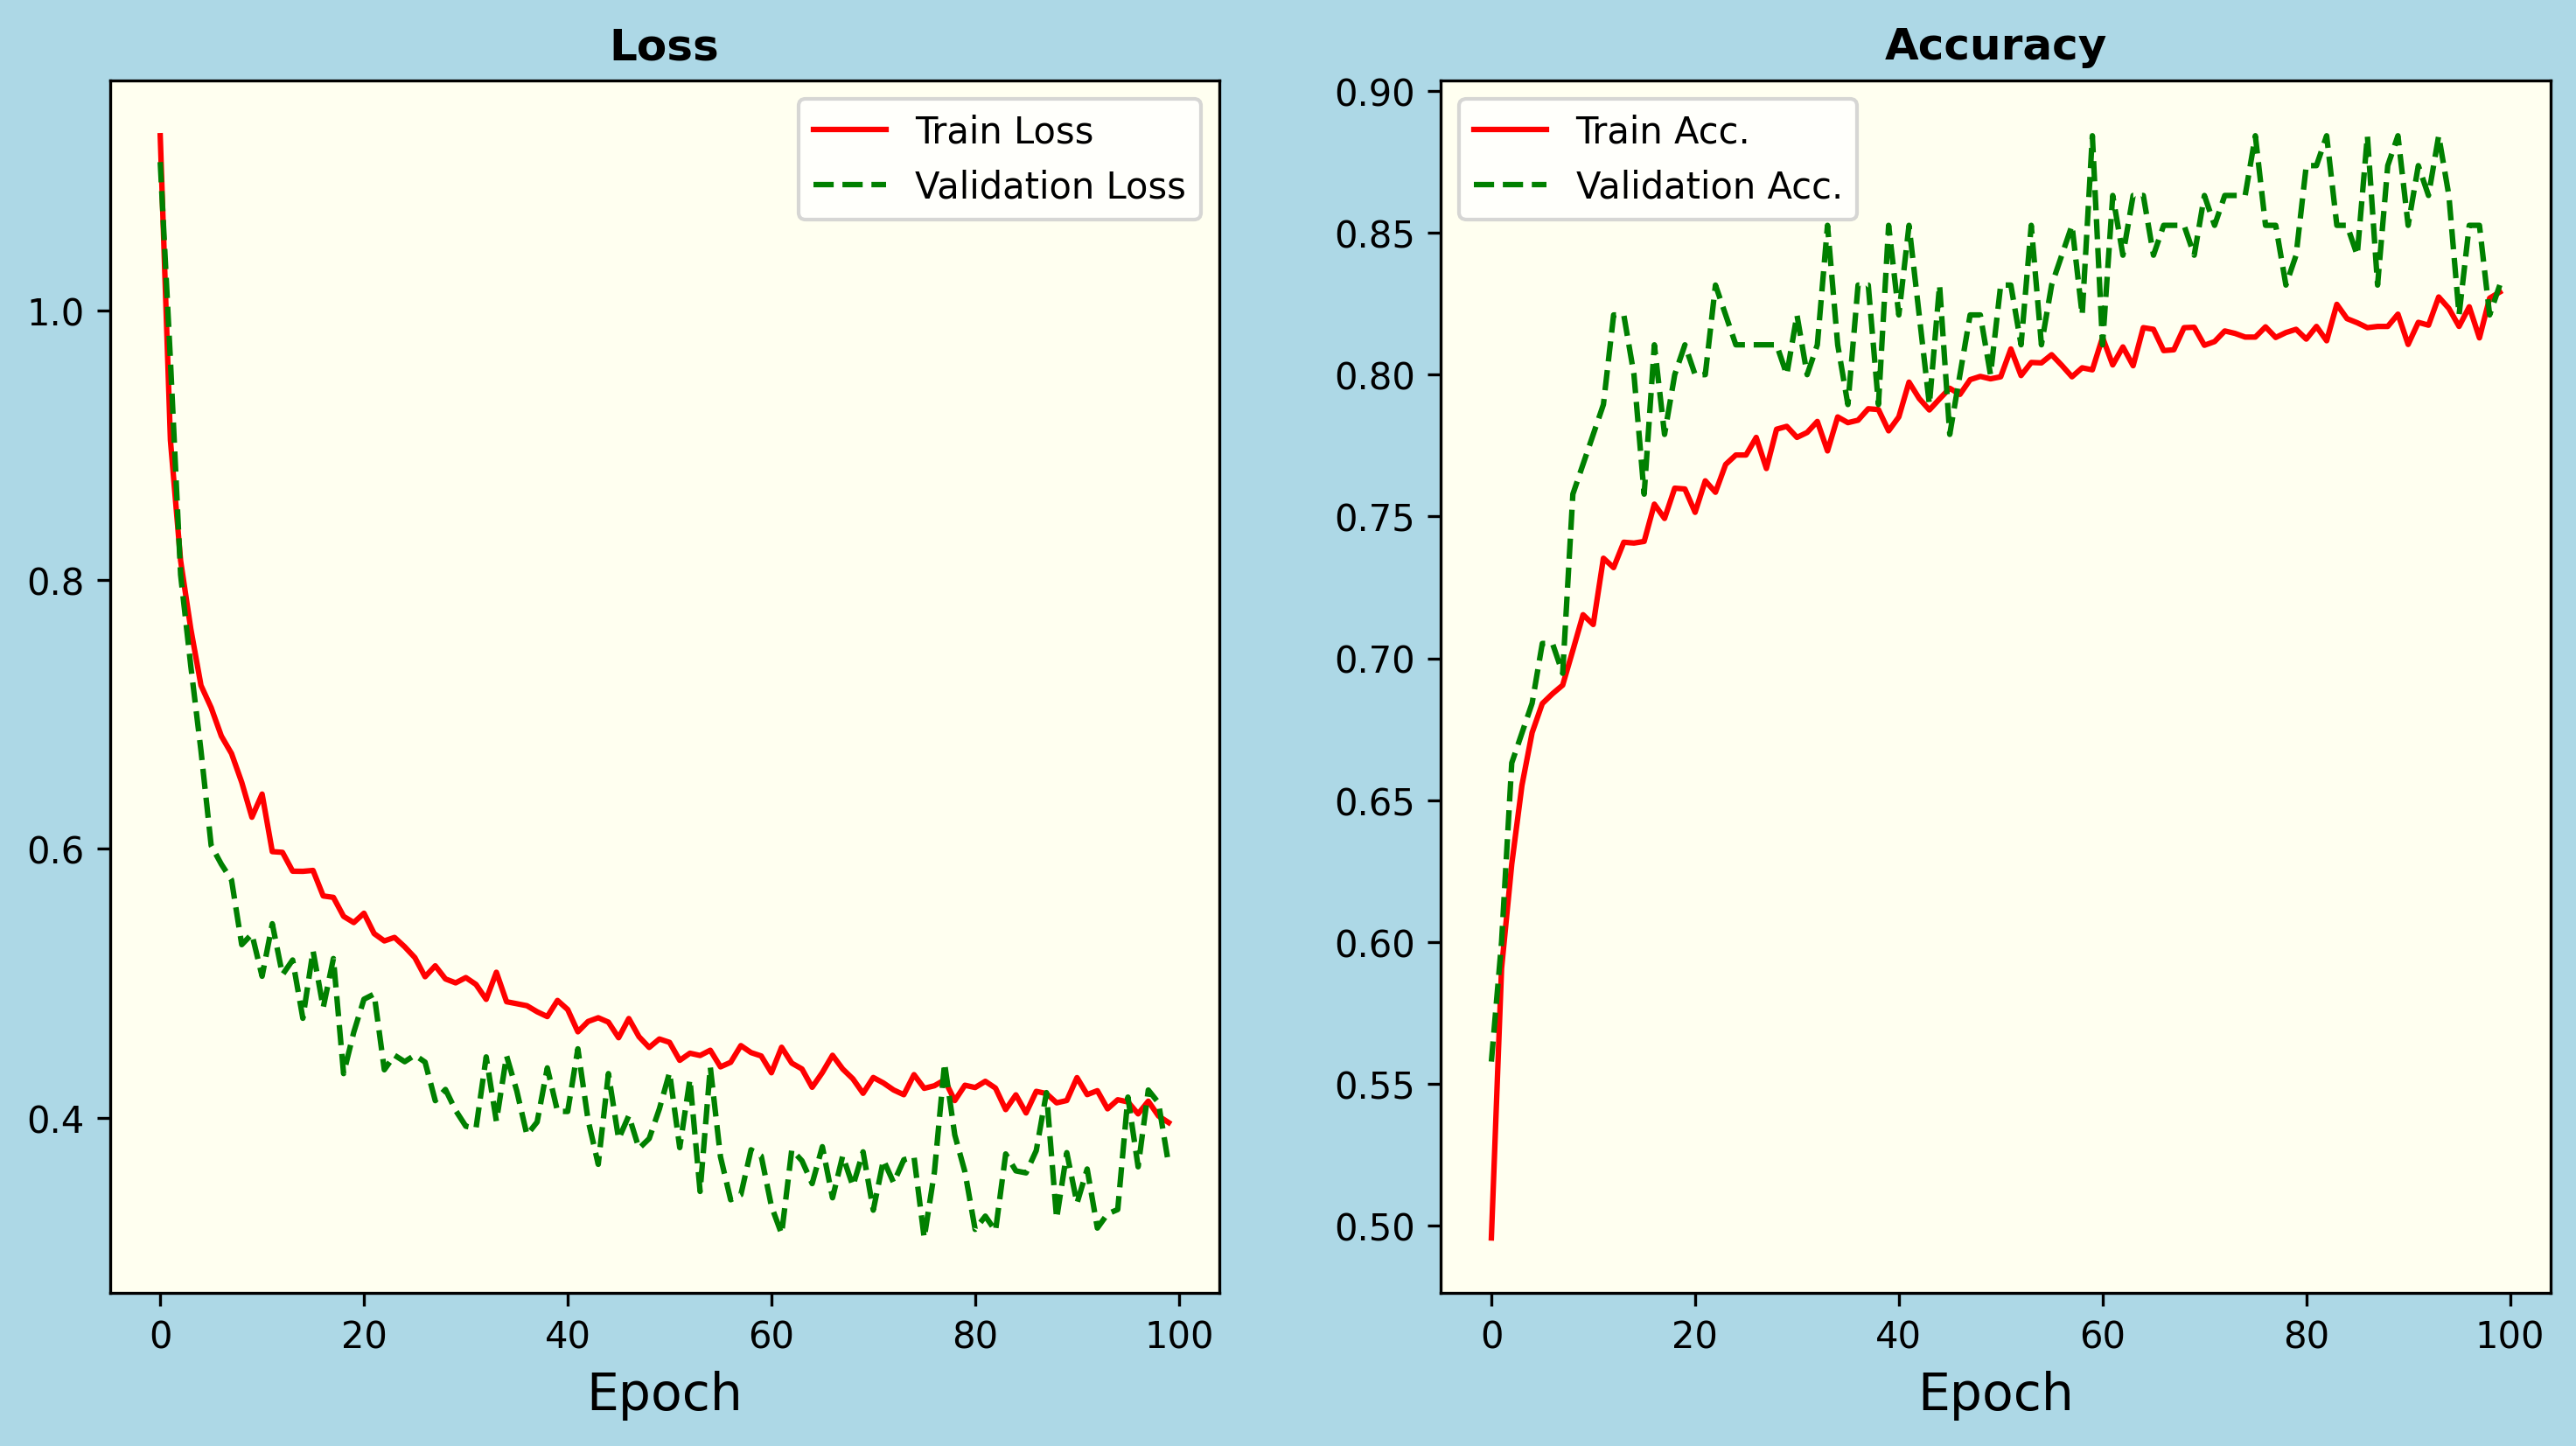

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12,6), facecolor="lightblue")
ax[0].set_facecolor('ivory')
ax[0].set_title('Loss', fontweight="bold")
ax[0].set_xlabel("Epoch", size=14)
ax[0].plot(history.epoch, history.history["loss"], label="Train Loss", color="red")
ax[0].plot(history.epoch, history.history["val_loss"], label="Validation Loss", color="green", linestyle="dashed")
ax[0].legend()
ax[1].set_facecolor('ivory')
ax[1].set_title('Accuracy', fontweight="bold")
ax[1].set_xlabel("Epoch", size=14)
ax[1].plot(history.epoch, history.history["accuracy"], label="Train Acc.", color="red")
ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Acc.", color="green", linestyle="dashed")
ax[1].legend()

45/45 ━━━━━━━━━━━━━━━━━━━━ 9s 192ms/step - accuracy: 0.8352 - loss: 0.4228
                  precision    recall  f1-score   support

    MildDemented    0.86744   0.86189   0.86466       782
ModerateDemented    0.97757   0.99430   0.98586       526
     NonDemented    0.82781   0.78223   0.80438       799
VeryMildDemented    0.75031   0.78934   0.76933       769

        accuracy                        0.84458      2876
       macro avg    0.85578   0.85694   0.85606      2876
    weighted avg    0.84525   0.84458   0.84459      2876



Text(287.1666666666666, 0.5, 'True')

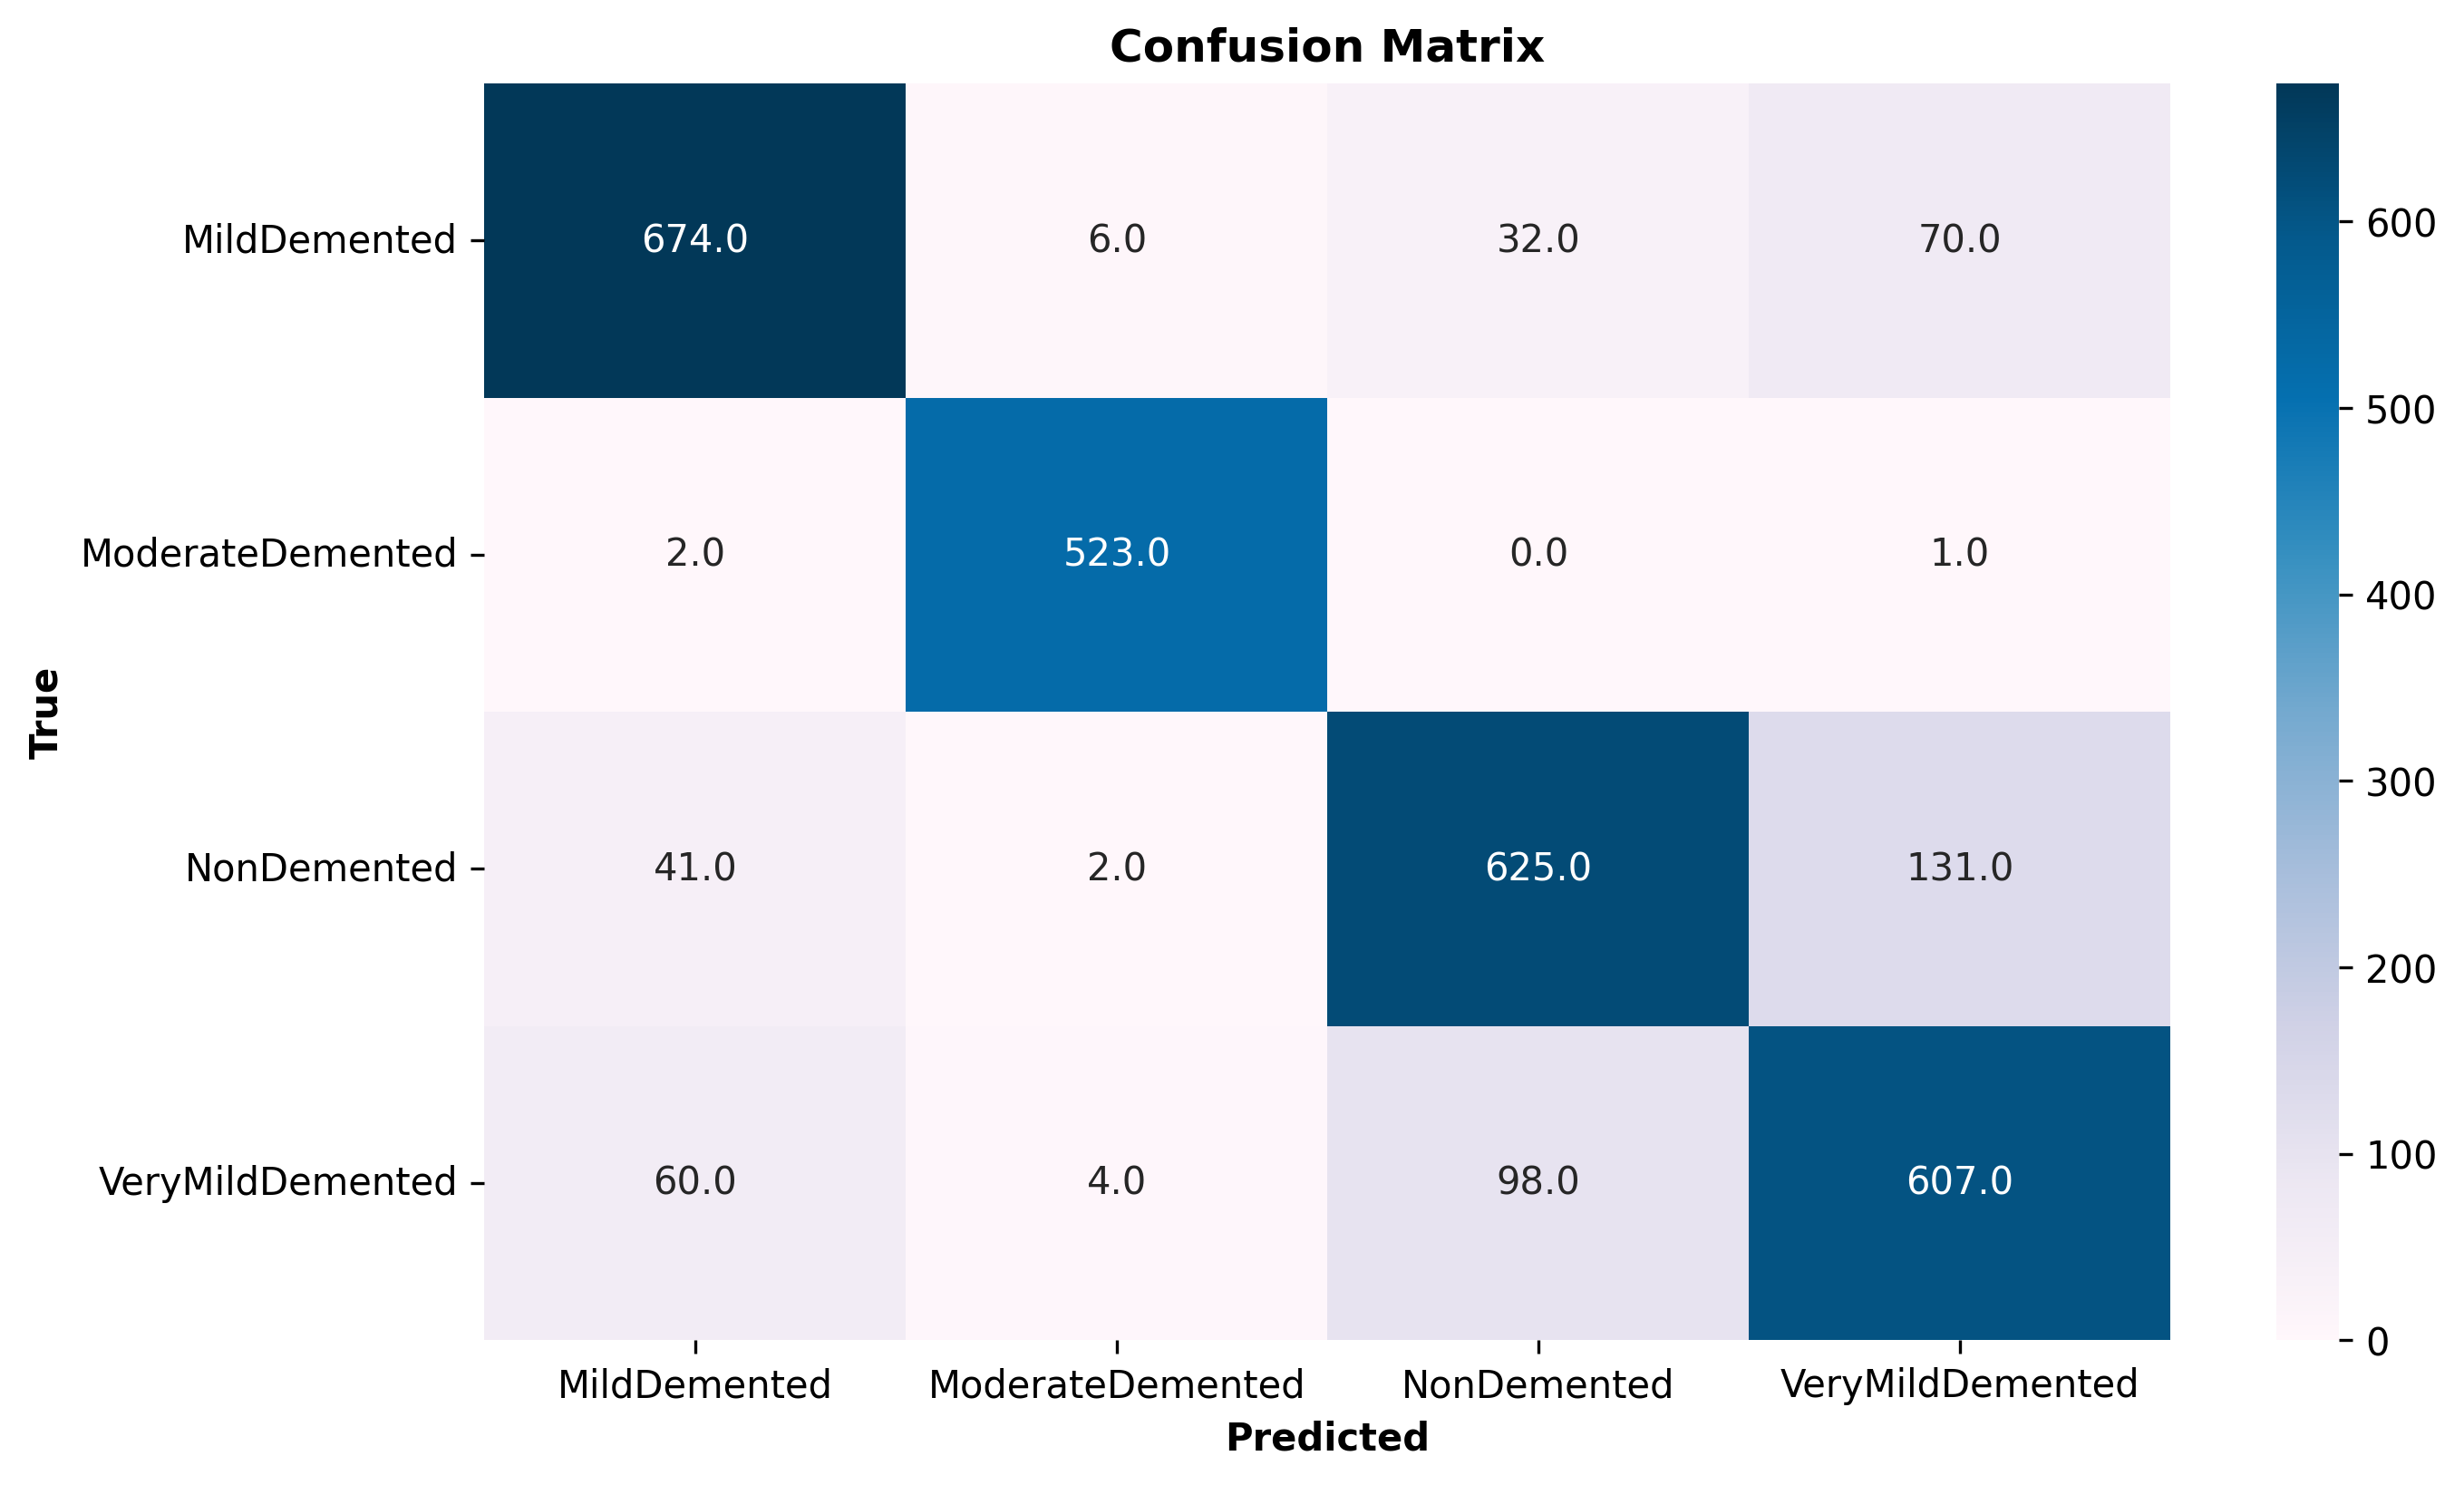

In [24]:
model.evaluate(test_data)

predictions = []
labels = []

for X, y in test_data.as_numpy_iterator():
    y_pred = model.predict(X, verbose=0)
    y_prediction = np.argmax(y_pred, axis=1)
    predictions.extend(y_prediction)
    labels.extend(y)

predictions = np.array(predictions)
labels = np.array(labels)

print(classification_report(labels, predictions, target_names=class_names, digits = 5))

cm = confusion_matrix(labels, predictions)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
cm_df
plt.figure(figsize=(10,6), dpi=300)
sns.heatmap(cm_df, annot=True, cmap="PuBu", fmt=".1f")
plt.title("Confusion Matrix", fontweight="bold")
plt.xlabel("Predicted", fontweight="bold")
plt.ylabel("True", fontweight="bold")